<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/get_results_and_features_stack_by_stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response and Stimulus

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#imports
!pip install hdf5storage
import hdf5storage 
import pandas as pd
import numpy as np
from scipy import ndimage
from tqdm import notebook
from more_itertools import sliced
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import copy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from os import listdir
root_path = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Stimulus_Features/allgood_except_stim4/' # This shows all stim features, but stim 4 is bad
file_paths = listdir(root_path)
date_fly_list = [f.split('_')[0] + '_' + f.split('_')[1] + '_' for f in file_paths]
movie_info_list = ['_' + f.split('_')[3] for f in file_paths]

In [3]:
# making sure each movie has all resp and stim data
for f in file_paths:
  results_file = hdf5storage.loadmat(root_path + f)
  print(list(results_file.keys()))

['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']
['resp', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8']


# Save Out Raw Data


In [4]:
#this is a combination of all the steps in cells below.
#Takes the index of the movie file in file_paths as the index
#returns a dataframe that holds the formatted raw data for that movie
#movie_ID, stack #, roi #, frame #, cell label, response, and all stim

def combine_resp_and_stim(i):

  #parse the filename to get the unique movie ID (date and fly index)
  movie_ID = "_".join(file_paths[i].split('_',2)[:2])
  print(movie_ID)

  #load the stimulus data of the i'th file
  results_file = hdf5storage.loadmat(root_path + file_paths[i]) # keys pulled from the first file

  #get a list of the keys in the h5 file
  keys = list(results_file.keys())

  #get number of frames in the movie
  num_frames = results_file[keys[0]][0,1][0].shape[0]

  #get number of stacks
  num_stacks = results_file[keys[0]].shape[1]

  #get number of rois
  num_rois = results_file[keys[0]][0,0].shape[0]

  print(num_frames*num_rois*num_stacks)


  #folder that holds the roi labels for all movies
  labels_folder = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'

  #get the filename of the csv that has the labels for this movie
  label_file = [f for f in listdir(labels_folder) if movie_ID in f and '.csv' in f][0]

  #read the csv , add the roi number, and drop the index and the stack name
  roi_labels = pd.read_csv(labels_folder+label_file)
  roi_labels['roi_number'] = roi_labels['index'] + 1
  roi_labels = roi_labels.drop(columns = ['index', 'stack'])

  #add the movie ID back as a column
  roi_labels['movie_ID'] = movie_ID

  #create a temporary df holding the stack numbers present in the movie
  #this will get crossmerged with the labels table to create a row for each roi in each stack
  temp_stack_df = pd.DataFrame(list(np.arange(num_stacks)+1), columns = ['stack_number'])

  #merge the tables
  roi_labels = roi_labels.merge(temp_stack_df, how='cross')


  #SETUP df to recieve resp and stim data

  # first create a table with stack, index, label, roi_number, and frame number to hold all the data
  # create a df with a row for every frame
  raw_data = pd.DataFrame({'frame': np.array(range(0,num_frames))})

  # use a cross merge to get the cross product for this table and the full_labels
  # this will give us a row for every frame for every roi in every stack
  raw_data = roi_labels.merge(raw_data, how='cross').rename(columns={'stack_number':'stack','roi_number':'roi'})
  raw_data = raw_data.set_index(['movie_ID','stack','label','roi','frame'])

  #At this point we have an empty row for every frame of every roi in every stack
  #labelled with the cell type and all indexes

  #STIM & RESP DATA

  #combine all stim and resp into a dataframe with the same format and order as the one we just made

  stim_data = copy.deepcopy(results_file)
  col = ['stack','roi', 'frame', 'l_label', 'stim_data']

  # dataframe for stimulus & response data
  s_df = pd.DataFrame(columns=col)

  #loop through the keys in the results file
  for l in keys:

    # for each key, loop through all the stacks
    for s in range(0,num_stacks):

      # create a 1D array for each column in df
      #length is (# of rois * # of frames)
      stim_data[l][0,s] = stim_data[l][0,s].reshape((num_rois * num_frames))
      stack = np.array([s + 1] * num_rois * num_frames)
      roi = np.array([[r+1] * num_frames for r in range(0,num_rois)]).flatten()
      frame_ind = np.array([list(range(0,num_frames)) * num_rois]).flatten()
      l_label = np.array([l] * num_rois * num_frames)

      # combine into 4D array
      data_array = np.stack((stack, roi, frame_ind, l_label, stim_data[l][0,s]), axis=1)
      
      # combine into df
      s_df = s_df.append(pd.DataFrame(columns=col, data=data_array)).astype({'stack': 'int32','roi': 'int32','frame': 'int32'})

  #Now s_df has the stimulus and response data in the same format

  # combine stimulus data with raw data
  raw_data = raw_data.reset_index()

  #loop through keys again
  for l in keys:

    #for each key, select a subset of the s_df that holds data for that key
    #then merge it into our empty raw data file
    raw_data = raw_data.merge(s_df[s_df.l_label == l],how='right',left_on=['stack','roi','frame'], right_on=['stack','roi','frame'])
    
    # name column after stimulus type
    raw_data = raw_data.rename(columns={'stim_data': l})

    # after adding to raw_data, drop the rows holding that key to save memory
    s_df = s_df[s_df.l_label != l]

    raw_data = raw_data.drop(columns=['l_label'])

  print(len(raw_data))
  return raw_data

In [6]:
# run this to save all data into csv's

# #loop through the indices of our movie files and save each to a csv

# from tqdm.auto import tqdm
# for i in tqdm(range(len(file_paths))):
#   movie_ID = "_".join(file_paths[i].split('_',2)[:2])
#   df = combine_resp_and_stim(i)
#   df.to_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/pre-feature extract/' + \
#                        movie_ID + '_RAW_extracted_data.csv')

## Explore data and select a Hold Out set

In [6]:
#loop through the indices of our movie files and save each to a csv

dfs = []

from tqdm.auto import tqdm
for i in tqdm(range(len(file_paths))):
  movie_ID = "_".join(file_paths[i].split('_',2)[:2])
  df = combine_resp_and_stim(i)
  dfs.append(df)

  0%|          | 0/9 [00:00<?, ?it/s]

210809_2
496170
496170
210728_0
694638
694638
210802_0
849002
849002
210808_0
827100
827100
210731_0
1273503
1273503
210815_1
92682
92682
210816_0
661560
661560
210815_0
716690
716690
210816_1
496170
496170


In [31]:
# create a unified data frame
df = dfs[0]
for i in range(len(dfs) - 1):
  df = pd.concat([df,dfs[i+1]])
df.head()

,movie_ID,stack,label,roi,frame,resp,stim1,stim2,stim3,stim4,stim5,stim6,stim7,stim8
0,210809_2,1,tm1,1,0,0.15462611957832814,0.5567626049363883,-0.9045481567562135,-1.8292015055938111,0.0,nan,0.0007139930639563896,3.460805630705712,1.9968226985830997
1,210809_2,1,tm1,1,1,0.0024509806127886503,0.5567626049363883,0.7764419060888778,-0.0013011010856999268,0.0,nan,0.022989559130627654,3.460805630705712,1.9968226985830997
2,210809_2,1,tm1,1,2,0.005994091720506429,0.5567626049363883,0.7764419060888778,-0.0013011010856999268,0.0,nan,0.09621458625461328,3.460805630705712,-2.0674298983696024
3,210809_2,1,tm1,1,3,0.2651824170710284,-0.5466431544278293,-0.9806418892132551,-1.8030030656274345,0.0,nan,0.24429478466655252,3.460805630705712,-2.0674298983696024
4,210809_2,1,tm1,1,4,0.3548365865753441,-1.2822469940039503,-0.9728680240768532,-1.8059681189362105,0.0,nan,0.4083994405688918,3.460805630705712,-2.0674298983696024


In [32]:
df.to_csv('TEMP-please delete after 3-35.csv')

In [5]:
df = pd.read_csv('TEMP-please delete after 3-35.csv')

In [6]:
df.movie_ID.unique() # check to see we got all the movies

array(['210809_2', '210728_0', '210802_0', '210808_0', '210731_0',
       '210815_1', '210816_0', '210815_0', '210816_1'], dtype=object)

In [7]:
# collapse to the ROI level
df_grouped = df.groupby(['label','movie_ID','roi']).min()
df_grouped

Unnamed: 0  stack  frame      resp     stim1     stim2  \
label movie_ID roi                                                           
t5    210731_0 19        99234      1      0 -0.573116 -2.772207 -2.008310   
               20       104747      1      0 -0.664213 -2.793183 -2.008309   
               21       110260      1      0 -0.685776 -2.804936 -2.008310   
      210802_0 14        71669      1      0 -0.587399 -2.784522 -2.011513   
      210809_2 8         38591      1      0 -0.827386 -2.780518 -2.009106   
...                        ...    ...    ...       ...       ...       ...   
tm9   210802_0 1             0      1      0 -1.111217 -2.801161 -2.011513   
      210815_0 8         38591      1      0 -0.830179 -2.816271 -2.011698   
               9         44104      1      0 -0.931173 -2.800848 -2.011698   
      210816_0 1             0      1      0 -0.503057 -2.823084 -2.013047   
               3         11026      1      0 -0.841731 -2.802233 -2.013047   

                       stim3     stim4  stim5     stim6     stim7     stim8  
label movie_ID roi                                                           
t5    210731_0 19  -1.889941 -3.102808    NaN -3.578059 -0.354780 -2.066676  
               20  -1.889947 -3.102808    0.0 -3.630513  0.000000  0.000000  
               21  -1.889947 -3.102808    NaN -3.542253 -0.354780 -2.066676  
      210802_0 14  -1.892105 -3.109418    0.0 -3.811278 -0.354792 -2.065421  
      210809_2 8   -1.890601 -3.105102    NaN -3.694999 -0.354506 -2.067430  
...                      ...       ...    ...       ...       ...       ...  
tm9   210802_0 1   -1.892107 -3.109418    NaN -3.569840 -0.354792 -2.065421  
      210815_0 8   -1.891862 -3.100499    0.0 -3.512411  0.000000  0.000000  
               9   -1.891832 -3.100499    0.0 -3.574564 -0.354134 -2.066294  
      210816_0 1   -1.893449 -3.108949    0.0 -3.322094  0.000000  0.000000  
               3   -1.893447 -3.108949    0.0 -3.955240  0.000000  0.000000  

[110 rows x 12 columns]

In [8]:
# count the number of rois for each label
num_lbl = df_grouped.reset_index().groupby('label').count()['roi']
num_lbl

label
t5      6
tm1    26
tm2    54
tm4    14
tm9    10
Name: roi, dtype: int64

In [9]:
# calculate the smallest number of rois for a balanced sample
s = 0
for n in num_lbl.index:
  num_r = np.round((num_lbl[n]/num_lbl.sum())*100/num_lbl.min())
  print(n,num_r) # prortion of each multiplied by 100 divided by lowest value to get the smallest validation set
  s+=num_r
print('Total: ',s)

t5 1.0
tm1 4.0
tm2 8.0
tm4 2.0
tm9 2.0
Total:  17.0


pull out roi's at random for validation file

In [10]:
# get a list of rois
t5 = df_grouped.loc['t5'].reset_index()[['movie_ID','roi']].sample(1)
tm1 = df_grouped.loc['tm1'].reset_index()[['movie_ID','roi']].sample(4)
tm2 = df_grouped.loc['tm2'].reset_index()[['movie_ID','roi']].sample(8)
tm4 = df_grouped.loc['tm4'].reset_index()[['movie_ID','roi']].sample(2)
tm9 = df_grouped.loc['tm9'].reset_index()[['movie_ID','roi']].sample(2)

# save in one list
val_list = pd.concat([t5,tm1,tm2,tm4,tm9])
val_list

,movie_ID,roi
1,210731_0,20
4,210802_0,8
12,210809_2,5
6,210808_0,5
20,210816_0,4
13,210731_0,7
30,210808_0,2
7,210728_0,10
3,210728_0,6
36,210808_0,14


In [11]:
# save everything from these rois in a seperate df (removing them from the other df)
df_val = pd.merge(val_list,df,on=['movie_ID','roi'], how='inner')
df_val.head()

,movie_ID,roi,Unnamed: 0,stack,label,frame,resp,stim1,stim2,stim3,stim4,stim5,stim6,stim7,stim8
0,210731_0,20,104747,1,t5,0,-0.135124,-2.091607,0.674834,-0.706352,0.0,0.0,0.000712,0.0,0.0
1,210731_0,20,104748,1,t5,1,-0.138022,-2.091607,0.776414,-0.001123,0.0,0.0,-0.070075,0.0,0.0
2,210731_0,20,104749,1,t5,2,-0.041196,-2.091607,0.776414,-0.001123,0.0,0.0,-0.313415,0.0,0.0
3,210731_0,20,104750,1,t5,3,-0.202763,0.107257,-1.823641,-0.876688,0.0,0.0,-0.812258,0.0,0.0
4,210731_0,20,104751,1,t5,4,-0.206614,1.573167,-1.595163,-1.303869,0.0,0.0,-1.442477,0.0,0.0


In [12]:
# check to make sure we have the right number of labels for each class
df_val.groupby(['movie_ID','roi']).min().sort_values('label')

Unnamed: 0  stack label  frame      resp     stim1     stim2  \
movie_ID roi                                                                 
210731_0 20       104747      1    t5      0 -0.664213 -2.793183 -2.008309   
210802_0 8         38591      1   tm1      0 -0.783239 -2.802472 -2.011513   
210809_2 5         22052      1   tm1      0 -0.937845 -2.802064 -2.009106   
210808_0 5         22056      1   tm1      0 -1.142423 -2.793243 -2.008264   
210816_0 4         16539      1   tm1      0 -0.833256 -2.794617 -2.013047   
210731_0 7         33078      1   tm2      0 -0.573374 -2.772207 -2.008310   
         2          5513      1   tm2      0 -0.513171 -2.802113 -2.008309   
210808_0 2          5514      1   tm2      0 -0.826982 -2.804384 -2.008264   
         9         44112      1   tm2      0 -0.849282 -2.801429 -2.008264   
         11        55140      1   tm2      0 -0.937988 -2.772866 -2.008264   
         14        71682      1   tm2      0 -1.086282 -2.804203 -2.008264   
210728_0 10        49617      1   tm2      0 -1.432492 -3.293003 -1.543852   
         6         27565      1   tm2      0 -0.482416 -3.253655 -1.543850   
210731_0 14        71669      1   tm4      0 -0.691087 -2.785042 -2.008310   
         4         16539      1   tm4      0 -0.715209 -2.802692 -2.008305   
210815_0 9         44104      1   tm9      0 -0.931173 -2.800848 -2.011698   
210728_0 14        71669      1   tm9      0 -0.615719 -3.248755 -1.543852   

                 stim3     stim4  stim5     stim6     stim7     stim8  
movie_ID roi                                                           
210731_0 20  -1.889947 -3.102808    0.0 -3.630513  0.000000  0.000000  
210802_0 8   -1.892106 -3.109418    0.0 -3.606035  0.000000  0.000000  
210809_2 5   -1.890601 -3.105102    NaN -3.737966 -0.354506 -2.067430  
210808_0 5   -1.891053 -3.102526    0.0 -3.448281  0.000000  0.000000  
210816_0 4   -1.893449 -3.108949    NaN -3.973974 -0.354167 -2.065734  
210731_0 7   -1.889941 -3.102808    NaN -3.578059 -0.354780 -2.066676  
         2   -1.889947 -3.102808    0.0 -3.523736  0.000000  0.000000  
210808_0 2   -1.891052 -3.102526    0.0 -3.983335  0.000000  0.000000  
         9   -1.891053 -3.102526    0.0 -3.573769 -0.353854 -2.066654  
         11  -1.891043 -3.102526    NaN -3.608321 -0.353854 -2.066654  
         14  -1.891054 -3.102526    NaN -3.618298 -0.353854 -2.066654  
210728_0 10  -1.421446 -2.496412    NaN -4.010526 -0.304940 -1.420206  
         6   -1.421441 -2.496412    NaN -3.781234 -0.304940 -1.420206  
210731_0 14  -1.889941 -3.102808    0.0 -3.464715 -0.354780 -2.066676  
         4   -1.889946 -3.102808    0.0 -3.667774  0.000000  0.000000  
210815_0 9   -1.891832 -3.100499    0.0 -3.574564 -0.354134 -2.066294  
210728_0 14  -1.421445 -2.496412    0.0 -3.603216  0.000000  0.000000

In [13]:
df.shape[0]-df_val.shape[0] # number of rows df should have when we drop the val rows

5153716

In [14]:
# make a list in index form of the rows we need to drop
mult_index = ['movie_ID','roi']
labels = val_list.set_index(mult_index).index
labels
df = df.set_index(mult_index)
df.loc[labels]

Unnamed: 0  stack label  frame      resp     stim1     stim2  \
movie_ID roi                                                                 
210731_0 20       104747      1    t5      0 -0.135124 -2.091607  0.674834   
         20       104748      1    t5      1 -0.138022 -2.091607  0.776414   
         20       104749      1    t5      2 -0.041196 -2.091607  0.776414   
         20       104750      1    t5      3 -0.202763  0.107257 -1.823641   
         20       104751      1    t5      4 -0.206614  1.573167 -1.595163   
...                  ...    ...   ...    ...       ...       ...       ...   
210815_0 9        694633     10   tm9   5508 -0.073490  1.604747  0.772458   
         9        694634     10   tm9   5509 -0.051779 -0.052993 -1.257135   
         9        694635     10   tm9   5510  0.198691 -0.384540 -1.352272   
         9        694636     10   tm9   5511  0.010810 -0.384540  0.772458   
         9        694637     10   tm9   5512  0.394413 -0.384540  0.772458   

                 stim3  stim4  stim5     stim6     stim7     stim8  
movie_ID roi                                                        
210731_0 20  -0.706352    0.0    0.0  0.000712  0.000000  0.000000  
         20  -0.001123    0.0    0.0 -0.070075  0.000000  0.000000  
         20  -0.001123    0.0    0.0 -0.313415  0.000000  0.000000  
         20  -0.876688    0.0    0.0 -0.812258  0.000000  0.000000  
         20  -1.303869    0.0    0.0 -1.442477  0.000000  0.000000  
...                ...    ...    ...       ...       ...       ...  
210815_0 9    0.007047    0.0    0.0  0.305090 -0.353377 -1.572868  
         9    1.666713    0.0    0.0  1.837153 -0.353377 -1.336189  
         9    1.591342    0.0    0.0  2.251051 -0.353377 -1.099509  
         9    0.007047    0.0    0.0  1.864755 -0.353377  1.030604  
         9    0.007047    0.0    0.0  1.184756 -0.353377  1.030604  

[953799 rows x 13 columns]

In [15]:
# drop columns in df_val
df = df.drop(index=labels)
df.head()

Unnamed: 0  stack label  frame      resp     stim1     stim2  \
movie_ID roi                                                                 
210809_2 1             0      1   tm1      0  0.154626  0.556763 -0.904548   
         1             1      1   tm1      1  0.002451  0.556763  0.776442   
         1             2      1   tm1      2  0.005994  0.556763  0.776442   
         1             3      1   tm1      3  0.265182 -0.546643 -0.980642   
         1             4      1   tm1      4  0.354837 -1.282247 -0.972868   

                 stim3  stim4  stim5     stim6     stim7     stim8  
movie_ID roi                                                        
210809_2 1   -1.829202    0.0    NaN  0.000714  3.460806  1.996823  
         1   -0.001301    0.0    NaN  0.022990  3.460806  1.996823  
         1   -0.001301    0.0    NaN  0.096215  3.460806 -2.067430  
         1   -1.803003    0.0    NaN  0.244295  3.460806 -2.067430  
         1   -1.805968    0.0    NaN  0.408399  3.460806 -2.067430

In [17]:
df.shape # correct number of rows

(5153716, 13)

In [19]:
# df.loc[labels] # after (looking for an error)

In [32]:
! ls drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/'pre-feature extract'

OLD-3-24


Save out data frames

In [36]:
path = "drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/pre-feature extract/"
df_val.to_csv(path + "HOLDOUT_RAW_extracted_data.csv")

In [38]:
df.to_csv(path + "TrainTest_RAW_extracted_data.csv")

In [ ]:
# #declare the movie we're extracting in two parts, the date and fly index, and the mix desctiption
# #we'll add the stack index inbetween when we extract the results
# date_fly = '210815_0_'
# movie_info = '_20220213T070259' # it looks like now carl is using more of a movie ID than discription

In [ ]:
# #This file contains the response and stimulus data for all stacks of this movie
# #The movie id on the end corresponds with the same stacks in the results file

# path = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Stimulus_Features/' + date_fly + 'stim' + movie_info + '_.mat'
# #read file in using hdf5 structure
# results_file = hdf5storage.loadmat(path)

In [ ]:
# # list the two main folders
# list(results_file.keys())

In [ ]:
# #the response and stimulus are now in a 1x(number of stacks) matrix
# #Note that some stacks were split into two shorter stacks where Carl had to remove sections due to equipment interference (or something)
# #There might be a different number of stacks here compared to the stackRaw's as a result
# results_file['resp'].shape

In [ ]:
# #each stack has a (# of rois) by (# of frames) matrix holding the fluorescence trace of the rois in that stack
# for x in results_file['resp'][0]:
#   print(x.shape)

In [ ]:
# #same for the stimulus values
# for x in results_file['stim1'][0]:
#   print(x.shape)

# Spatial footprints DEPRECATED

### If Carl has split any of the stacks for the response and stimulus features, we need to go into the 'results' folder and make a copy of that stack's caiman results so that the number of spatial result files matches the number of stacks

### This is not an elegant solution, but it works

In [ ]:
# #Filter the files in the results folder down to the h5 files that match this movie, then reconstruct the paths
# import os
# root = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'
# spatial_files = os.listdir(root)
# spatial_files = [s for s in spatial_files if date_fly in s and '.h5' in s]
# spatial_filepaths = [root + s for s in spatial_files]
# spatial_filepaths

In [ ]:
# #to order the paths by the stack number, put them in a pandas df, extract the stack number from the name, and sort by the number
# spatial_files_df = pd.DataFrame({
#     'filename': spatial_files,
#     'filepath': spatial_filepaths
# })

# #The filename starts with the date_flyIndex_stackIndex, so we split by "_" and take the 3rd segment (index 2)
# spatial_files_df['stack_number'] = spatial_files_df['filename'].str.split('_', expand=True)[2].astype(int)

# #sort by stack number to align the spatial files with the order of the stacks in the response and stimulus files
# spatial_files_df = spatial_files_df.sort_values('stack_number', ascending=True)
# spatial_files_df

In [ ]:
# # test that we can access each spatial file by printing the shape of the first roi mask in each file
# for x in spatial_files_df['filepath']:
#   with h5py.File(x, 'r') as file:
#     print(file['spatial'][0].shape)

In [ ]:
# #load all of the spatial matrices into memory for faster looping later - dictionary for now
# spatial_matrices = {}
# for stack_number in range(len(spatial_files_df)):
#   with h5py.File(spatial_files_df['filepath'][stack_number], 'r') as file:
#       spatial_matrices[stack_number] = file['spatial'][()].astype(bool).astype(int) #convert values to integer 0/1 representation of footprint

In [ ]:
# #double check the shape of the first stack's matrix - should be (# of rois) by (# of pixels)
# spatial_matrices[0].shape

# Cell type labels

# Stimulus Data read and exploration

In [ ]:
label_csv['stack'].value_counts()

210731_0_1_stackRaw_mc_mix2_syt_                             21
210808_0_1_stackRaw_mc_result_20220309T012702                15
210728_0_1_stackRaw_mc_tm2_tm9_syt_result_20220309T002951    14
210802_0_1_stackRaw_mc_result_20220308T122044                14
210815_0_1_stackRaw_mc_mix1_syt_result_20220308T134319       13
210816_0_1_stackRaw_mc_                                      12
210816_1_1_stackRaw_mc_                                      10
210809_2_1_stackRaw_mc_                                       9
210815_1_1_stackRaw_mc_                                       2
Name: stack, dtype: int64

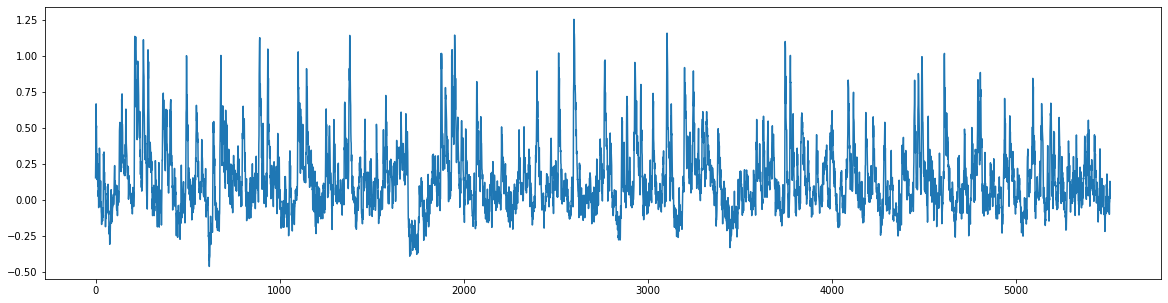

In [ ]:
#visualize temporal traces - first roi
#indexing to the response subfolder, then into the array of stacks, then into the first stack, then into the first roi
temporal = results_file['resp'][0][0][0]
plt.figure(figsize=(20,5))
plt.plot(temporal)

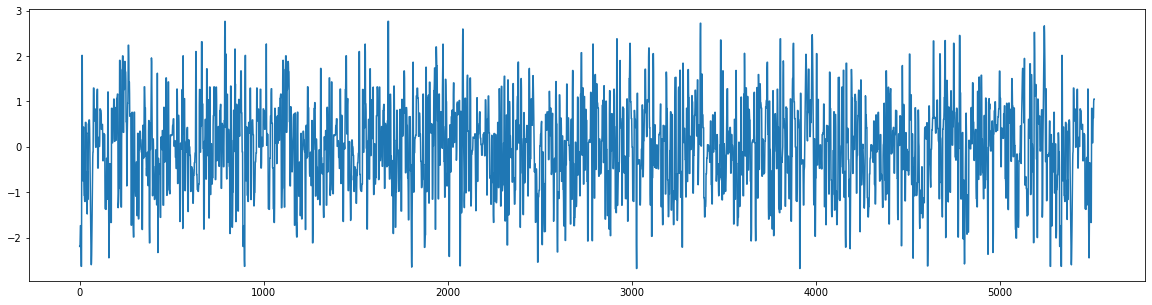

In [ ]:
#visualize stimulus traces - first roi
#indexing to the response subfolder, then into the array of stacks, then into the first stack, then into the first roi
temporal = results_file['stim1'][0][0][0]
plt.figure(figsize=(20,5))
plt.plot(temporal)

# Extract features from each roi in the file

In [ ]:
# #IMPORTANT
# #Set the time period in frames that we want to consider here
# #If 1, then we're doing no temporal collapsing, just taking the fluorescence / stimulus
# #if >1, then we return the mean, min, max fluorescence over chunks of that length

# temporal_period_length = 20

# #Calculate the number of stacks and the number of rois to loop through
# num_stacks = len(results_file['resp'][0])
# num_rois = len(results_file['resp'][0][0])
# print(f"Extracting raw features for {num_rois} rois across {num_stacks} stacks")

In [ ]:
# file number
# Change this to run a different file
i = 0
movie_ID = "_".join(file_paths[i].split('_',2)[:2])
file_paths[i]

'210809_2_stim_20220308T131617_.mat'

In [ ]:
results_file = hdf5storage.loadmat(root_path + file_paths[i]) # keys pulled from the first file

keys = list(results_file.keys())
keys

['resp',
 'stim1',
 'stim2',
 'stim3',
 'stim4',
 'stim5',
 'stim6',
 'stim7',
 'stim8']

In [ ]:
# make sure the shapes of each key match
for l in keys:
  print(results_file[l].shape)

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


In [ ]:
# save number of frames
num_frames = results_file[keys[0]][0,1][0].shape[0]
print(num_frames)
# get number of stacks
num_stacks = results_file[keys[0]].shape[1]
print(num_stacks)
# get number of rois
num_rois = results_file[keys[0]][0,0].shape[0]
print(num_rois)

print(num_frames*num_rois*num_stacks)

5513
10
9
496170


In [ ]:

#folder that holds the roi labels for all movies
labels_folder = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'

#get the filename of the csv that has the labels for this movie
label_file = [f for f in listdir(labels_folder) if movie_ID in f and '.csv' in f][0]

#read the csv , add the roi number, and drop the index and the stack name
roi_labels = pd.read_csv(labels_folder+label_file)
roi_labels['roi_number'] = roi_labels['index'] + 1
roi_labels = roi_labels.drop(columns = ['index', 'stack'])

#add the movie ID back as a column
roi_labels['movie_ID'] = movie_ID
roi_labels

,label,roi_number,movie_ID
0,tm1,1,210809_2
1,tm1,2,210809_2
2,tm1,3,210809_2
3,tm1,4,210809_2
4,tm1,5,210809_2
5,tm1,6,210809_2
6,tm1,7,210809_2
7,t5,8,210809_2
8,t5,9,210809_2


In [ ]:
temp_stack_df = pd.DataFrame(list(np.arange(num_stacks)+1), columns = ['stack_number'])
temp_stack_df

,stack_number
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [ ]:
roi_labels = roi_labels.merge(temp_stack_df, how='cross')
roi_labels


,label,roi_number,movie_ID,stack_number
0,tm1,1,210809_2,1
1,tm1,1,210809_2,2
2,tm1,1,210809_2,3
3,tm1,1,210809_2,4
4,tm1,1,210809_2,5
...,...,...,...,...
85,t5,9,210809_2,6
86,t5,9,210809_2,7
87,t5,9,210809_2,8
88,t5,9,210809_2,9


In [ ]:
# #code to check if any of the fields are coming in without any values from the stimulus files
# for f in file_paths:
#   results_file = hdf5storage.loadmat(root_path + file_paths[i])
#   keys = list(results_file.keys())
#   print(f)
#   for key in keys:
#     print(key)
#     print(sum(~np.isnan(results_file[key][0][0][0])))

In [ ]:
# check that all data is the same size for each stack
for l in keys:
  print(l)
  for s in range(0,results_file[l].shape[1]): # loop through number of stacks
    print(results_file[l][0,s].shape) # prints shape of each stack
  print('----------')

resp
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim1
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim2
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim3
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim4
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim5
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim6
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim7
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
----------
stim8
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)
(9, 5513)

In [ ]:
# this is just a reference to understand the path through the object
results_file[keys[0]][0,1][0].shape # first category, first stack, first roi, all the frames

(5513,)

#### Base DataFrame

In [ ]:
# #Filter the files in the results folder down to the h5 files that match this movie, then reconstruct the paths
# import os
# root = '/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Results/'
# spatial_files = os.listdir(root)
# spatial_files = [s for s in spatial_files if date_fly_list[i] in s and '.h5' in s]
# spatial_filepaths = [root + s for s in spatial_files]
# spatial_filepaths

In [ ]:
# #to order the paths by the stack number, put them in a pandas df, extract the stack number from the name, and sort by the number
# spatial_files_df = pd.DataFrame({
#     'filename': spatial_files,
#     'filepath': spatial_filepaths
# })

# #The filename starts with the date_flyIndex_stackIndex, so we split by "_" and take the 3rd segment (index 2)
# spatial_files_df['stack_number'] = spatial_files_df['filename'].str.split('_', expand=True)[2].astype(int)

# #we don't need the filepath, we need a unique ID for each stack (stack_ID)
# spatial_files_df

# #sort by stack number to align the spatial files with the order of the stacks in the response and stimulus files
# spatial_files_df = spatial_files_df.sort_values('stack_number', ascending=True)
# spatial_files_df

In [ ]:
# # test that we can access each spatial file by printing the shape of the first roi mask in each file
# for x in spatial_files_df['filepath']:
#   with h5py.File(x, 'r') as file:
#     print(file['spatial'][0].shape)

In [ ]:
# #load all of the spatial matrices into memory for faster looping later - dictionary for now
# spatial_matrices = {}
# for stack_number in range(len(spatial_files_df)):
#   with h5py.File(spatial_files_df['filepath'][stack_number], 'r') as file:
#       spatial_matrices[stack_number] = file['spatial'][()].astype(bool).astype(int) #convert values to integer 0/1 representation of footprint

In [ ]:
# #double check the shape of the first stack's matrix - should be (# of rois) by (# of pixels)
# spatial_matrices[0].shape

#### Add Features to DF

In [ ]:
# compile into df


# first create a table with stack, index, label, roi_number, and frame number to hold all the data
# create a df with a row for every frame
raw_data = pd.DataFrame({'frame': np.array(range(0,num_frames))})
print(raw_data.shape)


# use a cross merge to get the cross product for this table and the full_labels
# this will give us a row for every frame for every roi in every stack
raw_data = roi_labels.merge(raw_data, how='cross').rename(columns={'stack_number':'stack','roi_number':'roi'})
print(raw_data.shape)
raw_data = raw_data.set_index(['movie_ID','stack','label','roi','frame'])
raw_data

# note that frames start at 0 and roi's start at 1

(5513, 1)
(496170, 5)


Empty DataFrame
Columns: []
Index: [(210809_2, 1, tm1, 1, 0), (210809_2, 1, tm1, 1, 1), (210809_2, 1, tm1, 1, 2), (210809_2, 1, tm1, 1, 3), (210809_2, 1, tm1, 1, 4), (210809_2, 1, tm1, 1, 5), (210809_2, 1, tm1, 1, 6), (210809_2, 1, tm1, 1, 7), (210809_2, 1, tm1, 1, 8), (210809_2, 1, tm1, 1, 9), (210809_2, 1, tm1, 1, 10), (210809_2, 1, tm1, 1, 11), (210809_2, 1, tm1, 1, 12), (210809_2, 1, tm1, 1, 13), (210809_2, 1, tm1, 1, 14), (210809_2, 1, tm1, 1, 15), (210809_2, 1, tm1, 1, 16), (210809_2, 1, tm1, 1, 17), (210809_2, 1, tm1, 1, 18), (210809_2, 1, tm1, 1, 19), (210809_2, 1, tm1, 1, 20), (210809_2, 1, tm1, 1, 21), (210809_2, 1, tm1, 1, 22), (210809_2, 1, tm1, 1, 23), (210809_2, 1, tm1, 1, 24), (210809_2, 1, tm1, 1, 25), (210809_2, 1, tm1, 1, 26), (210809_2, 1, tm1, 1, 27), (210809_2, 1, tm1, 1, 28), (210809_2, 1, tm1, 1, 29), (210809_2, 1, tm1, 1, 30), (210809_2, 1, tm1, 1, 31), (210809_2, 1, tm1, 1, 32), (210809_2, 1, tm1, 1, 33), (210809_2, 1, tm1, 1, 34), (210809_2, 1, tm1, 1, 35), (210809_2, 1, tm1, 1, 36), (210809_2, 1, tm1, 1, 37), (210809_2, 1, tm1, 1, 38), (210809_2, 1, tm1, 1, 39), (210809_2, 1, tm1, 1, 40), (210809_2, 1, tm1, 1, 41), (210809_2, 1, tm1, 1, 42), (210809_2, 1, tm1, 1, 43), (210809_2, 1, tm1, 1, 44), (210809_2, 1, tm1, 1, 45), (210809_2, 1, tm1, 1, 46), (210809_2, 1, tm1, 1, 47), (210809_2, 1, tm1, 1, 48), (210809_2, 1, tm1, 1, 49), (210809_2, 1, tm1, 1, 50), (210809_2, 1, tm1, 1, 51), (210809_2, 1, tm1, 1, 52), (210809_2, 1, tm1, 1, 53), (210809_2, 1, tm1, 1, 54), (210809_2, 1, tm1, 1, 55), (210809_2, 1, tm1, 1, 56), (210809_2, 1, tm1, 1, 57), (210809_2, 1, tm1, 1, 58), (210809_2, 1, tm1, 1, 59), (210809_2, 1, tm1, 1, 60), (210809_2, 1, tm1, 1, 61), (210809_2, 1, tm1, 1, 62), (210809_2, 1, tm1, 1, 63), (210809_2, 1, tm1, 1, 64), (210809_2, 1, tm1, 1, 65), (210809_2, 1, tm1, 1, 66), (210809_2, 1, tm1, 1, 67), (210809_2, 1, tm1, 1, 68), (210809_2, 1, tm1, 1, 69), (210809_2, 1, tm1, 1, 70), (210809_2, 1, tm1, 1, 71), (210809_2, 1, tm1, 1, 72), (210809_2, 1, tm1, 1, 73), (210809_2, 1, tm1, 1, 74), (210809_2, 1, tm1, 1, 75), (210809_2, 1, tm1, 1, 76), (210809_2, 1, tm1, 1, 77), (210809_2, 1, tm1, 1, 78), (210809_2, 1, tm1, 1, 79), (210809_2, 1, tm1, 1, 80), (210809_2, 1, tm1, 1, 81), (210809_2, 1, tm1, 1, 82), (210809_2, 1, tm1, 1, 83), (210809_2, 1, tm1, 1, 84), (210809_2, 1, tm1, 1, 85), (210809_2, 1, tm1, 1, 86), (210809_2, 1, tm1, 1, 87), (210809_2, 1, tm1, 1, 88), (210809_2, 1, tm1, 1, 89), (210809_2, 1, tm1, 1, 90), (210809_2, 1, tm1, 1, 91), (210809_2, 1, tm1, 1, 92), (210809_2, 1, tm1, 1, 93), (210809_2, 1, tm1, 1, 94), (210809_2, 1, tm1, 1, 95), (210809_2, 1, tm1, 1, 96), (210809_2, 1, tm1, 1, 97), (210809_2, 1, tm1, 1, 98), (210809_2, 1, tm1, 1, 99), ...]

[496170 rows x 0 columns]

In [ ]:
# combine all stimulus data into one dataframe


stim_data = copy.deepcopy(results_file)
col = ['stack','roi', 'frame', 'l_label', 'stim_data']

# dataframe for stimulus data
s_df = pd.DataFrame(columns=col)
for l in keys:

  # loop through all the stacks
  for s in range(0,num_stacks):
    # s_df = pd.DataFrame(columns=['stack','roi','resp','stim1','stim2','stim3'])
    # for r in range(0,num_rois):

    # create a 1D array for each column in df
    stim_data[l][0,s] = stim_data[l][0,s].reshape((num_rois * num_frames))
    stack = np.array([s + 1] * num_rois * num_frames)
    roi = np.array([[r + 1] * num_frames for r in range(0,num_rois)]).flatten()
    frame_ind = np.array([list(range(0,num_frames)) * num_rois]).flatten()
    l_label = np.array([l] * num_rois * num_frames)

  # combine into 4D array
  data_array = np.stack((stack, roi, frame_ind, l_label, stim_data[l][0,s]), axis=1)
    
  # combine into df
  s_df = s_df.append(pd.DataFrame(columns=col, data=data_array)).astype({'stack': 'int32','roi': 'int32','frame': 'int32'})

# s_df = s_df.pivot(columns=['stack','roi','stim_data'], values='l_label') # this crashes (out of ram)
s_df

,stack,roi,frame,l_label,stim_data
0,10,1,0,resp,-0.5796362791180557
1,10,1,1,resp,-0.5368578348534263
2,10,1,2,resp,-0.3831613538294825
3,10,1,3,resp,-0.2164506973257827
4,10,1,4,resp,0.06288149494873506
...,...,...,...,...,...
49612,10,9,5508,stim8,-0.6250467177208144
49613,10,9,5509,stim8,-0.388474385184362
49614,10,9,5510,stim8,-0.388474385184362
49615,10,9,5511,stim8,-0.388474385184362


In [ ]:
# combine stimulus data with raw data
raw_data = raw_data.reset_index()
for l in keys:
  raw_data = raw_data.merge(s_df[s_df.l_label == l],how='right',left_on=['stack','roi','frame'], right_on=['stack','roi','frame'])
  # name column after stimulus type
  raw_data = raw_data.rename(columns={'stim_data': l})

  # after adding to raw_data, drop data to save memory
  s_df = s_df[s_df.l_label != l]

  raw_data = raw_data.drop(columns=['l_label'])

raw_data# = raw_data.drop(['stack','roi'])

,movie_ID,stack,label,roi,frame,resp,stim1,stim2,stim3,stim4,stim5,stim6,stim7,stim8
0,210809_2,10,tm1,1,0,-0.5796362791180557,-1.1469466336473615,0.7710212245104429,-0.07472577311941418,0.0,nan,0.0002858950027431879,-0.35333451742059513,-2.0444807129395293
1,210809_2,10,tm1,1,1,-0.5368578348534263,-1.1469466336473615,0.7723298893750463,0.007046866626577275,0.0,nan,-0.03827157102334716,-0.35333451742059513,-2.0444807129395293
2,210809_2,10,tm1,1,2,-0.3831613538294825,-1.1469466336473615,0.7723298893750463,0.007046866626577275,0.0,nan,-0.17293790900628764,-0.35333451742059513,-2.0444807129395293
3,210809_2,10,tm1,1,3,-0.2164506973257827,-0.6907152373692823,-1.8455882584861036,-0.8325759204840161,0.0,nan,-0.4502860241253449,-0.35333451742059513,-2.0444807129395293
4,210809_2,10,tm1,1,4,0.06288149494873506,-0.3865609731838943,-1.719587237945664,-1.111817854968053,0.0,nan,-0.8401683699772676,-0.35333451742059513,-2.0444807129395293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49612,210809_2,10,t5,9,5508,0.2618595088177626,-1.8001701481673997,0.7723298893750463,0.007046866626577275,0.0,nan,-0.8667615743973006,-0.35333451742059513,-0.6250467177208144
49613,210809_2,10,t5,9,5509,0.11128738825161567,-0.26507417167679564,-1.6752931248854939,-1.188845212973743,0.0,nan,-1.5439810837278793,0.3266112836410113,-0.388474385184362
49614,210809_2,10,t5,9,5510,-0.009039699013167776,0.5024738165685149,-1.8638424827519227,-0.7809030586509161,0.0,nan,-1.6855616242888887,-0.35333451742059513,-0.388474385184362
49615,210809_2,10,t5,9,5511,-0.02405178761898816,0.5024738165685149,0.7723298893750463,0.007046866626577275,0.0,nan,-1.3564103638891991,-0.35333451742059513,-0.388474385184362


In [ ]:
raw_data.to_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/pre-feature extract/' + \
                      movie_ID + '_RAW_extracted_data.csv')

## !! need to decide how to handle indexing for stacks that have been split. Right now this treats the split as two different stacks and we end up with more stacks than originally recorded ( 10 original stacks, one was split, now we have 11)

In [ ]:
# dims = [128,256]

# #loop through the stacks
# for stack_index in notebook.tqdm(range(num_stacks), desc='stack', position=0):

#   #open the corresponding spatial file and grab the spatial matrix
#   spatial_matrix = spatial_matrices[stack_index]
  
#   #grab the corresponding response matrix from the results file
#   response_matrix = results_file['resp'][0][stack_index]

#   #grab the corresponding stimulus 1 matrix
#   stim1_matrix = results_file['stim1'][0][stack_index]
  
#   #set up different dataframes depending on if we're collpsing temporal features or not
#   if temporal_period_length == 1:

#     roi_features = pd.DataFrame(columns =['roi_ID',
#                                         'area',
#                                         'center_of_mass_row',
#                                         'center_of_mass_column',
#                                         'resp',
#                                         'stim1',
#                                         'label',
#                                         'frame_number'])
    
#   else:
#     roi_features = pd.DataFrame(columns =['roi_ID',
#                                       'area',
#                                       'center_of_mass_row',
#                                       'center_of_mass_column',
#                                       'mean_resp',
#                                       'min_resp',
#                                       'max_resp',
#                                       'mean_stim1',
#                                       'min_stim1',
#                                       'max_stim1',
#                                       'label',
#                                       'start_frame_number'])

#   #loop through rois in each file and extract features
#   for roi_index in notebook.tqdm(range(num_rois), desc='roi', position=1, leave=False):

#     roi_spatial = spatial_matrix[roi_index] #spatial footprint of the x'th roi
#     roi_response = response_matrix[roi_index] #temporal trace of the x'th roi
#     roi_stim1 = stim1_matrix[roi_index] #stim1 feature for the x'th roi
#     roi_label = label_csv['label'][roi_index] #cell type label of the x'th roi
#     #comcatenated ID for the roi - date, fly index, stack number, roi index, mix
#     roi_ID = date_fly + str(stack_index + 1) + "_" + str(roi_index) + movie_info 

#     #calculate spatial measures for this roi
#     area = np.sum(roi_spatial)
#     spatial_img = np.reshape(roi_spatial, dims, order="F")
#     center_of_mass_row, center_of_mass_column = ndimage.center_of_mass(spatial_img)
    
#     #If one sample is one frame, no temporal slicing necessary
#     if temporal_period_length == 1:

#       #loop through all frames in the stack for both stimulus and response
#       for frame in range(len(roi_response)):

#         response = roi_response[frame] #loop through frames
#         stim1 = roi_stim1[frame] #and loop through stimulus

#         roi_features = roi_features.append({'roi_ID': roi_ID,
#                                             'area': area,
#                                             'center_of_mass_row': center_of_mass_row,
#                                             'center_of_mass_column': center_of_mass_column,
#                                             'resp': response,
#                                             'stim1': stim1,
#                                             'label': roi_label,
#                                             'frame_number': frame}, ignore_index=True)
        
#     else:

#       #list of lists containing the sliced up fluorescence values, one chunk has the length set in temporal_period_length
#       response_slices = list(sliced(roi_response, temporal_period_length))
#       stim1_slices = list(sliced(roi_stim1, temporal_period_length))

#       #loop through slices and extract collapsed temporal features for each slice
#       for temporal_slice in notebook.tqdm(range(len(response_slices)), desc='frame slices', position=2, leave=False):

#         #check if we're at the end of a stack by checking how many frames are in the chunk
#         #if the length of this chunk is the full length we expect, continue
#         if len(response_slices[temporal_slice]) == temporal_period_length:

#           start_frame_number = temporal_period_length * temporal_slice

#           mean_resp = np.mean(response_slices[temporal_slice]) #loop through frames
#           min_resp = np.min(response_slices[temporal_slice])
#           max_resp = np.max(response_slices[temporal_slice])

#           mean_stim1 = np.mean(stim1_slices[temporal_slice]) #loop through frames
#           min_stim1 = np.min(stim1_slices[temporal_slice])
#           max_stim1 = np.max(stim1_slices[temporal_slice])

#           roi_features = roi_features.append({'roi_ID': roi_ID,
#                                               'area': area,
#                                               'center_of_mass_row': center_of_mass_row,
#                                               'center_of_mass_column': center_of_mass_column,
#                                               'mean_resp': mean_resp,
#                                               'min_resp': min_resp,
#                                               'max_resp': max_resp,
#                                               'mean_stim1': mean_stim1,
#                                               'min_stim1': min_stim1,
#                                               'max_stim1': max_stim1,
#                                               'label': roi_label,
#                                               'start_frame_number': start_frame_number}, ignore_index=True)
          

#   print(f"saving {len(roi_features)} records to {'/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/' + \
#                       date_fly + str(stack_index +1) + movie_info + str(temporal_period_length)  + 'frameWindow_rawExtract.csv'}")  
        
#   #save the features - uses the file info declared at the top, , the stack number, and the temporal window
#   roi_features.to_csv('/content/drive/MyDrive/DS6011_Capstone_VisualNeuroscience/Seeded_CNMF/Extracted_Features/' + \
#                       date_fly + str(stack_index +1) + movie_info + str(temporal_period_length)  + 'frameWindow_rawExtract.csv')